In [0]:
import gym
import matplotlib.pyplot as plt
import random
from matplotlib import animation
from collections import deque
import time
import os
#from google.colab import drive

In [0]:
#drive.mount('/content/gdrive')

In [0]:
# def save_frames_as_gif(frames, filename=None):
#     """
#     Save a list of frames as a gif
#     """
#     patch = plt.imshow(frames[0])
#     plt.axis('off')
#     def animate(i):
#         patch.set_data(frames[i])
#     anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
#     if filename:
#         anim.save(filename, dpi=72, writer='imagemagick')

In [0]:
import numpy as np

# preprocessing used by Karpathy (cf. https://gist.github.com/karpathy/a4166c7fe253700972fcbc77e4ea32c5)
def prepro(I):
    """ prepro 210x160x3 uint8 frame into 6400 (80x80) 1D float vector """
    I = I[35:195] # crop
    I = I[::2,::2,0] # downsample by factor of 2
    I[I == 144] = 0 # erase background (background type 1)
    I[I == 109] = 0 # erase background (background type 2)
    I[I != 0] = 1 # everything else (paddles, ball) just set to 1
    return I.astype(np.float)

# Our Stronks AI

In [0]:
import torch.nn as nn
import torch
cuda = torch.cuda.is_available()
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torch.autograd import Variable
from torchvision.transforms import ToTensor
from functools import reduce
import torch.nn.functional as F

In [0]:
class ReplayMemory(object):
    """Experience Replay Memory"""
    
    def __init__(self, capacity):
        #self.size = size
        self.memory = deque(maxlen=capacity)
    
    def add(self, *args):
        """Add experience to memory."""
        self.memory.append([*args])
    
    def sample(self, batch_size):
        """Sample batch of experiences from memory with replacement."""
        return random.sample(self.memory, batch_size)
    
    def count(self):
        return len(self.memory)

In [0]:
# Atrari wrappers https://github.com/Shmuma/ptan/blob/master/samples/dqn_speedup/lib/atari_wrappers.py
class NoopResetEnv(gym.Wrapper):
    def __init__(self, env, noop_max=30):
        """Sample initial states by taking random number of no-ops on reset.
        No-op is assumed to be action 0.
        """
        gym.Wrapper.__init__(self, env)
        self.noop_max = noop_max
        self.override_num_noops = None
        self.noop_action = 0
        assert env.unwrapped.get_action_meanings()[0] == 'NOOP'

    def _reset(self, **kwargs):
        """ Do no-op action for a number of steps in [1, noop_max]."""
        self.env.reset(**kwargs)
        if self.override_num_noops is not None:
            noops = self.override_num_noops
        else:
            noops = self.unwrapped.np_random.randint(1, self.noop_max + 1) #pylint: disable=E1101
        assert noops > 0
        obs = None
        for _ in range(noops):
            obs, _, done, _ = self.env.step(self.noop_action)
            if done:
                obs = self.env.reset(**kwargs)
        return obs

class EpisodicLifeEnv(gym.Wrapper):
    def __init__(self, env=None):
        """Make end-of-life == end-of-episode, but only reset on true game over.
        Done by DeepMind for the DQN and co. since it helps value estimation.
        """
        super(EpisodicLifeEnv, self).__init__(env)
        self.lives = 0
        self.was_real_done = True
        self.was_real_reset = False

    def _step(self, action):
        obs, reward, done, info = self.env.step(action)
        self.was_real_done = done
        # check current lives, make loss of life terminal,
        # then update lives to handle bonus lives
        lives = self.env.unwrapped.ale.lives()
        if lives < self.lives and lives > 0:
            # for Qbert somtimes we stay in lives == 0 condtion for a few frames
            # so its important to keep lives > 0, so that we only reset once
            # the environment advertises done.
            done = True
        self.lives = lives
        return obs, reward, done, info

    def _reset(self):
        """Reset only when lives are exhausted.
        This way all states are still reachable even though lives are episodic,
        and the learner need not know about any of this behind-the-scenes.
        """
        if self.was_real_done:
            obs = self.env.reset()
            self.was_real_reset = True
        else:
            # no-op step to advance from terminal/lost life state
            obs, _, _, _ = self.env.step(0)
            self.was_real_reset = False
        self.lives = self.env.unwrapped.ale.lives()
        return obs


class FireResetEnv(gym.Wrapper):
    def __init__(self, env=None):
        """For environments where the user need to press FIRE for the game to start."""
        super(FireResetEnv, self).__init__(env)
        assert env.unwrapped.get_action_meanings()[1] == 'FIRE'
        assert len(env.unwrapped.get_action_meanings()) >= 3

    def _reset(self):
        self.env.reset()
        obs, _, done, _ = self.env.step(1)
        if done:
            self.env.reset()
        obs, _, done, _ = self.env.step(2)
        if done:
            self.env.reset()
        return obs

class MaxAndSkipEnv(gym.Wrapper):
    def __init__(self, env=None, skip=4):
        """Return only every `skip`-th frame"""
        super(MaxAndSkipEnv, self).__init__(env)
        # most recent raw observations (for max pooling across time steps)
        self._obs_buffer = deque(maxlen=2)
        self._skip = skip

    def step(self, action):
        total_reward = 0.0
        done = None
        for _ in range(self._skip):
            obs, reward, done, info = self.env.step(action)
            self._obs_buffer.append(obs)
            total_reward += reward
            if done:
                break

        max_frame = np.max(np.stack(self._obs_buffer), axis=0)

        return max_frame, total_reward, done, info

    def reset(self):
        """Clear past frame buffer and init. to first obs. from inner env."""
        self._obs_buffer.clear()
        obs = self.env.reset()
        self._obs_buffer.append(obs)
        return obs

def make_atari(env_id):
    env = gym.make(env_id)
    assert 'NoFrameskip' in env.spec.id
    if 'FIRE' in env.unwrapped.get_action_meanings():
        env = FireResetEnv(env)
    env = EpisodicLifeEnv(env)
    env = NoopResetEnv(env, noop_max=30)
    env = MaxAndSkipEnv(env, skip=4)
    return env

This fills replay buffer before first training

In [0]:
replay_memory_capacity = 50000
initial_memory_size = 0.2*replay_memory_capacity
prefill_memory = True
#env = gym.make("PongDeterministic-v4")
env = make_atari('PongNoFrameskip-v4')
replay_memory = ReplayMemory(replay_memory_capacity)
frame_counter = 0

def sample_action():
    n = np.random.uniform(0,1)
    if n <= 1/3:
        return 0
    elif n <= 2/3:
        return 2
    else:
        return 3

# prefill replay memory with random actions
# STATE = FRAME DIFFS, PREV/CUR_INPUT = STILL FRAMES
if prefill_memory:
    print('prefill replay memory')
    prev_input = np.zeros((80,80))
    env.reset()
    for i in range(12):
        env.step(0)
    state0,_,_,_ = env.step(0)
    #Preprocess frames - currently set to diff between frame
    cur_input = prepro(state0)
    state = (cur_input - prev_input).reshape(1,80,80)
    #change to convolution format
    prev_input = cur_input.copy() #Saving for next time to find direction of ball

    while replay_memory.count() <= initial_memory_size:
        action = sample_action()
        # _, reward, done, _ = env.step(action)
        state_raw, reward, done, info = env.step(action)
        cur_input = prepro(state_raw)
        state1 = (cur_input - prev_input).reshape(1,80,80) #diff between 
        replay_memory.add(state, action, reward, state1, done)
        #previous inpurt is the raw, state is the previous diff
        if not done:
            prev_input,state = cur_input.copy(),state1.copy()
        else:
            env.reset()
            for i in range(12):
                env.step(0)
            state_raw,_,_,_ = env.step(0)
            prev_input = prepro(state_raw).reshape(1,80,80)
            state = prev_input.copy()
            

prefill replay memory


In [0]:
class DQN(nn.Module):
    def __init__(self, input_features = 2304, output_layer = 3):
        super(DQN,self).__init__()
        
        self.out = nn.Sequential(
            nn.Linear(input_features, 512),
            nn.ReLU(),
            nn.Linear(512,output_layer)
        )
            

        self.convolutions = nn.Sequential(
            nn.Conv2d(in_channels = 1, out_channels=32, kernel_size = 8, stride = 4),
            nn.ReLU(),
            nn.Conv2d(32,64,5,2),
            nn.ReLU(),
            nn.Conv2d(64,64,3,1),
            nn.ReLU()
        )
    
    def forward(self,x):
        x = self.convolutions(x)
        x = x.view(x.size(0), -1)
        #print(x.size())
        out = self.out(x)
        return out

    #sum squared diff
    def loss(self, q_outputs, q_targets):
        return torch.sum(torch.pow(q_targets - q_outputs, 2))
    
    def update_params(self,new_params,tau):
        params = self.state_dict()
        for k in params.keys():
            params[k] = (1-tau) * params[k] + tau * new_params[k]
        self.load_state_dict(params)

In [0]:
def Wrap_modelstate(epoch,model,optimizer,epsilon,target_network,replay,reward):
    Model_dict = {'epoch': epoch + 1,
                  'epsilon': epsilon,
                  'state_dict': model.state_dict(),
                  'optimizer': optimizer.state_dict(),
                  'target_network':target_network.state_dict(),
                  'replay_buffer':replay,
                  'ep_reward':reward}
    return Model_dict

In [0]:
num_episodes = 1000
max_frames = 1100
#episode_explore = 10
epsilon = 1.0
rewards, lengths, losses, epsilons = [], [], [], []
x_train, y_train, rewards = [],[],[]
batch_size = 32
prev_input = np.zeros((80,80))
reward_sum = 0
n_outputs = 3
cwd = os.getcwd()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# initialize DQN and replay memory
policy_dqn = DQN().to(device)
policy_optimizer = optim.Adam(policy_dqn.parameters(),lr=1e-4)

target_dqn = DQN().to(device)
target_dqn.load_state_dict(policy_dqn.state_dict())

epsilon = 1
rewards, lengths, losses, epsilons = [], [], [], []

In [0]:
# load = True

# if load:
#     model_save_name = 'classifier.pt'
#     path = F"/content/gdrive/My Drive/" + model_save_name

#     checkpoint = torch.load(path)
#     policy_dqn.load_state_dict(checkpoint['policy_dqn'])
#     target_dqn.load_state_dict(checkpoint['target_dqn'])
# #    policy_dqn.optimizer.load_state_dict(checkpoint['optimizer'])
#     replay_memory = checkpoint['replay_mem']
#     episode = checkpoint['epoch']
#     epsilon = checkpoint['epsilon']
#     loss = checkpoint['loss']

In [0]:
gamma = 0.99 # discount rate
tau = 0.01 # target network update rate
val_freq = 200 # validation frequency
action_counter = {'0':0,'2':0,'3':0}
reward_log = {}
capture = False
frames = []
play_steps = 4
epsilon = 1
epsilon_start = 1
epsilon_end = 0.02
epsilon_decay_rate = 150*1000

start_time = time.time()

for episode in range(num_episodes):
  
    ep_reward, ep_loss = 0,0,
    env.reset()
    for i in range(12):
        env.step(0)
    s_raw,_,_,_ = env.step(0)
    prev_input = prepro(state_raw)
    s = prev_input.copy().reshape(1,80,80)
    #if save replay
    if capture: frames.append(s_raw)

    frame_counter = 1

    # if episode == val_freq: #Save model on validation frequency
    #   model_save_name = 'classifier.pt'
    #   path = F"/content/gdrive/My Drive/" + model_save_name
    #   torch.save({
    #       'epoch': episode +1,
    #       'policy_dqn': policy_dqn.state_dict(),
    #       'target_dqn': target_dqn.state_dict(),
    #       #'optimizer': policy_dqn.policy_optimizer.state_dict(),
    #       'replay_mem': replay_memory,
    #       'epsilon': epsilon,
    #       'loss': loss
    #   }, path)
    #   print('model saved')
    #policy_optimizer, policy_dqn
    for frame in range(max_frames):

        for i in range(play_steps):
            #Explore vs exploit
            if np.random.rand() < epsilon:
                a = sample_action()
            else:
                with torch.no_grad():
                    s_tmp = torch.from_numpy(s.reshape(1,1,80,80)).float().to(device)
                    a = policy_dqn(s_tmp).argmax().item()
                    a +=1 if a != 0 else a

            # perform action
            action_counter[str(a)] += 1
            # _, r, done, _ = env.step(a)
            # ep_reward += r
            s1_raw, r, done, _ = env.step(a)
            #if save replay
            if capture: frames.append(s1_raw)

            cur_input = prepro(s1_raw)
            s1 = (cur_input - prev_input).reshape(1,80,80)

            # store experience in replay memory
            replay_memory.add(s, a, r, s1, done)
            
            s = s1.copy()
            prev_input = cur_input.copy()
            ep_reward += r
            frame_counter += 1
            
            if done: 
                break

        if replay_memory.count() >= batch_size:
            
            batch = replay_memory.sample(batch_size)
            for i in range(play_steps-1):
                batch.extend(replay_memory.sample(batch_size))
                
            # sample batch from replay memory
            batch = np.array(batch) #shape: [batch_size, 5]
            #Since we sample from replay buffer, and it is filled with state_differences, we don't need to worry about subtraction here.
            ss, aa, rr, ss1, dd = batch[:,0], batch[:,1], batch[:,2], batch[:,3], batch[:,4]

            # do forward pass of batch
            policy_optimizer.zero_grad()
            ss = torch.from_numpy(np.stack(ss)).float().to(device)
            Q = policy_dqn(ss)

            with torch.no_grad():
                # TODO: use target net
                ss1 = torch.from_numpy(np.stack(ss1)).float().to(device)
                Q1 = target_dqn(ss1)
            
            # compute target for each sampled experience
            q_targets = Q.clone()

            #calculate q_targets 
            for k in range(batch_size):
                aa[k] -=1 if aa[k] != 0 else aa[k]
                q_targets[k, aa[k]] = rr[k] + gamma * Q1[k].max().item() * (not dd[k])
                
            # update network weights
            loss = policy_dqn.loss(Q, q_targets)
            loss.backward()
            policy_optimizer.step()
            # update target network parameters from policy network parameters
            target_dqn.update_params(policy_dqn.state_dict(), tau)
        ep_loss += loss.item()
        
        if done: 
            break

    #Logging
    reward_log[str(episode)] = ep_reward
    # new epsilon https://medium.com/@shmuma/speeding-up-dqn-on-pytorch-solving-pong-in-30-minutes-81a1bd2dff55
    if epsilon > 0.01:
        epsilon *= 0.9935
    else:
        epsilon = 0.01
    
    #epsilon *= num_episodes/(episode/(num_episodes/20)+num_episodes) # decrease epsilon
    epsilons.append(round(epsilon,2)); rewards.append(ep_reward); lengths.append(frame*play_steps+1); losses.append(ep_loss) #bookkeping
    
    #Printing
    print('{} EPISODE: {}:, reward:{}, frames: {}, epsilon: {}, last_{}_avgR: {}'.format(
        time.strftime('%X %x'),episode,ep_reward,frame_counter,epsilon,100,round(np.mean(rewards[-100:]),2)))

    # saving gif
    # if capture:
    #     gif = '/content/drive/My Drive/Pong_gifs/frameDiffEpsiode' + str(episode) + '.gif'
    #     save_frames_as_gif(frames, filename=gif)
    #     capture = False
    #     frames = []

    #Change validation frequency, if model performs well.
    if round(np.mean(rewards[-100:]) > 0):
        val_freq = 100

    #capture gif
    #if (episode+1) % (val_freq) == 0:
        #capturing
        #frames, capture = [], True
        
    if int(time.time()-start_time) > 82800:
        break




02:10:16 01/03/20 EPISODE: 0:, reward:-20.0, frames: 967, epsilon: 0.9935, last_100_avgR: -20.0
02:10:21 01/03/20 EPISODE: 1:, reward:-20.0, frames: 969, epsilon: 0.9870422500000001, last_100_avgR: -20.0
02:10:26 01/03/20 EPISODE: 2:, reward:-20.0, frames: 1028, epsilon: 0.9806264753750001, last_100_avgR: -20.0
02:10:30 01/03/20 EPISODE: 3:, reward:-21.0, frames: 933, epsilon: 0.9742524032850627, last_100_avgR: -20.25
02:10:35 01/03/20 EPISODE: 4:, reward:-19.0, frames: 1005, epsilon: 0.9679197626637098, last_100_avgR: -20.0
02:10:39 01/03/20 EPISODE: 5:, reward:-21.0, frames: 814, epsilon: 0.9616282842063958, last_100_avgR: -20.17
02:10:45 01/03/20 EPISODE: 6:, reward:-19.0, frames: 1185, epsilon: 0.9553777003590542, last_100_avgR: -20.0
02:10:51 01/03/20 EPISODE: 7:, reward:-21.0, frames: 1174, epsilon: 0.9491677453067204, last_100_avgR: -20.12
02:10:56 01/03/20 EPISODE: 8:, reward:-21.0, frames: 994, epsilon: 0.9429981549622268, last_100_avgR: -20.22
02:11:00 01/03/20 EPISODE: 9:, r

In [0]:
replay_memory.count()

50000

In [0]:
outfile = open('framediff_log.txt','w')
print(epsilons,file=outfile)
print(lengths,file=outfile)
print(rewards,file=outfile)
print(losses,file=outfile)
outfile.close()

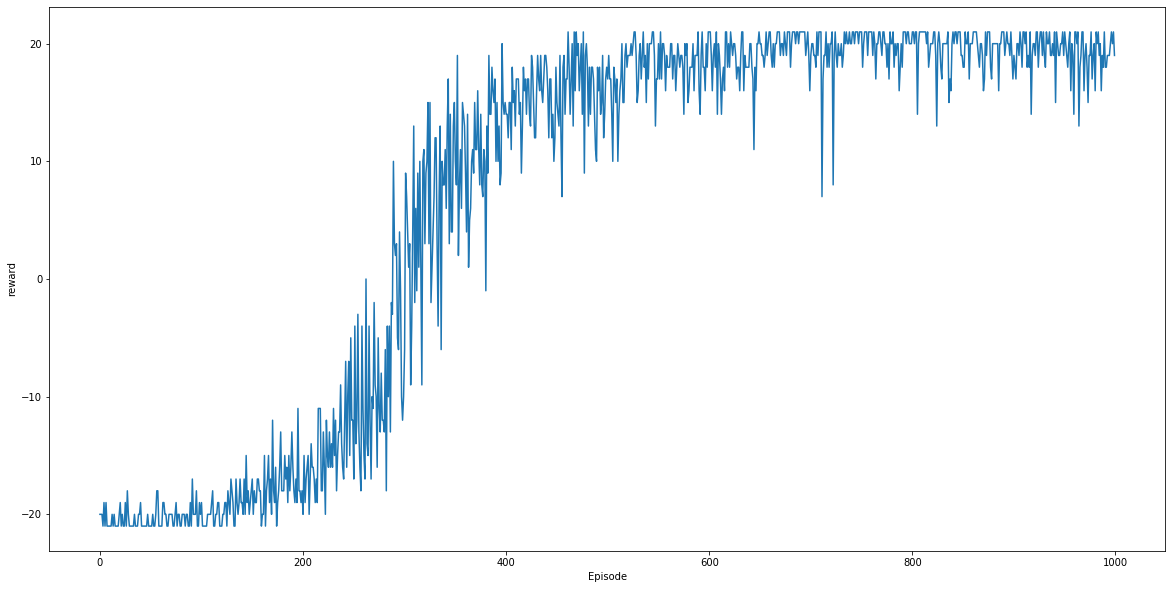

In [0]:
import seaborn as sns
x_vals = list(map(int,reward_log.keys()))
y_vals = [reward_log[str(k)] for k in x_vals]

fig,ax = plt.subplots(figsize=(20,10))
#plt.locator_params(axis='x',nbins=10)
ax.set_xlabel('Episode')
ax.set_ylabel('reward')

ax.plot(x_vals,y_vals)
#plt.show()
fig.savefig('frame_diff_reward.png')